<a href="https://colab.research.google.com/github/Elisabet-CueliAlba-ECA/trump-macroeconomic-policy-portfolio-analysis/blob/main/Project_Active_Portfolio_Management_Facing_Donald_Trump's_tariff_policies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import missingno as mso
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import skew, kurtosis, norm
from scipy.linalg import sqrtm
import cvxpy as cp



#Construcción de la cartera

In [ ]:
tickers=['MCHI', 'INDA', 'ITA', 'XLV', 'TIP', 'GLD', 'TSM', 'AVGO', 'XLP']

w = np.array([0.05, 0.03, 0.2, 0.20, 0.17, 0.20, 0.03, 0.02, 0.1])

indice=['ACWI'] #All Country World Index: global, cubre tanto mercados desarrollados como emergentes


In [ ]:
activos=yf.download(tickers,auto_adjust=True,start='2019-01-01')['Close']

[*********************100%***********************]  9 of 9 completed


In [ ]:
activos=activos.dropna(axis=0,how='any')

<Axes: xlabel='Date'>

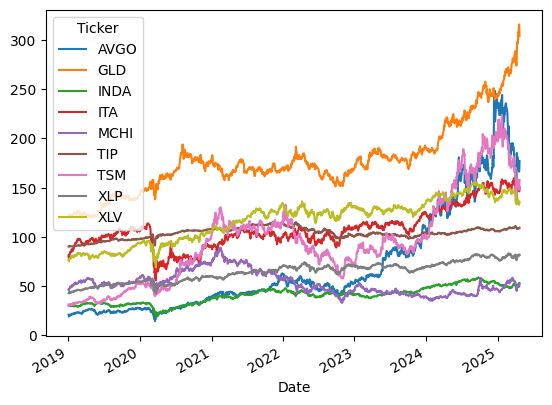

In [ ]:
activos.plot()

In [ ]:
activos_price=activos @ w.T
activos_price#[-1]

,0
Date,
2019-01-02,62.415508
2019-01-03,61.431724
2019-01-04,62.648638
2019-01-07,62.828540
2019-01-08,63.234970
...,...
2025-04-16,108.008100
2025-04-17,108.019001
2025-04-21,107.075102


In [ ]:
activos_ret=np.log(activos).diff().dropna()

<Axes: xlabel='Date'>

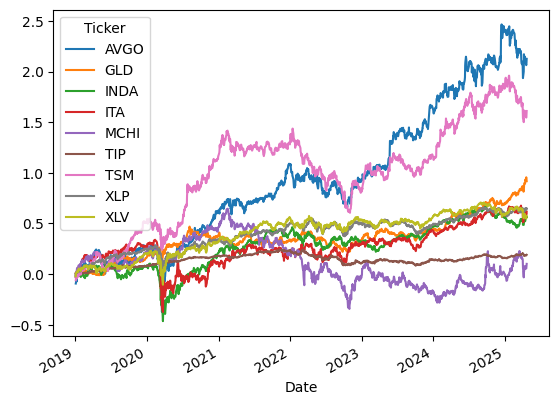

In [ ]:
activos_ret.cumsum().plot()

<Axes: xlabel='Ticker', ylabel='Ticker'>

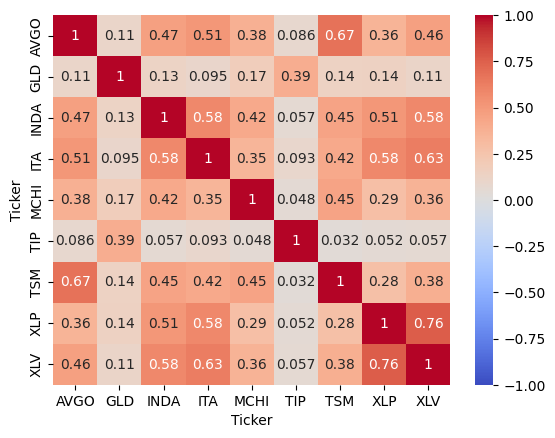

In [ ]:
sns.heatmap(activos_ret.corr(),cmap='coolwarm',vmin=-1,vmax=1,annot=True)

In [ ]:
ind=yf.download(indice,auto_adjust=True)['Close'].dropna(axis=0,how='any')

[*********************100%***********************]  1 of 1 completed


In [ ]:
ind_ret=np.log(ind).diff().dropna()

In [ ]:
cartera_ret=activos_ret @ w.T
cartera_ret.shape

(1585,)

In [ ]:
cartera_ret_m=cartera_ret.mean()
cartera_std=cartera_ret.std()
print(cartera_ret_m*252,cartera_std*np.sqrt(252))

0.08644123634023007 0.15690178553901846


In [ ]:
cartera_ret.name='Cartera'

In [ ]:
cartera_ret

,Cartera
Date,
2019-01-03,-0.021802
2019-01-04,0.023195
2019-01-07,0.001935
2019-01-08,0.005540
2019-01-09,0.008185
...,...
2025-04-16,-0.006376
2025-04-17,0.003801
2025-04-21,-0.005700


<Axes: xlabel='Date'>

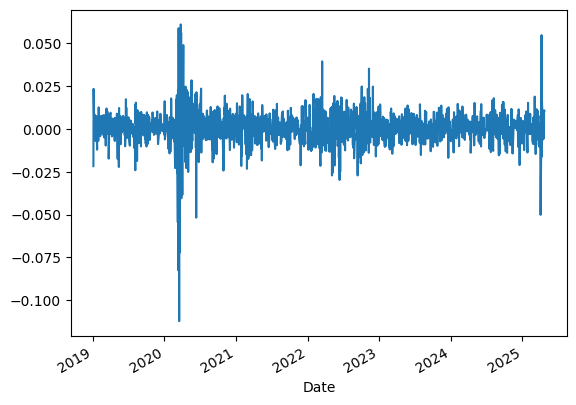

In [ ]:
cartera_ret.plot()

In [ ]:
df_cart_acwi=pd.concat([cartera_ret,ind_ret],join='inner',axis=1)

<Axes: xlabel='Date'>

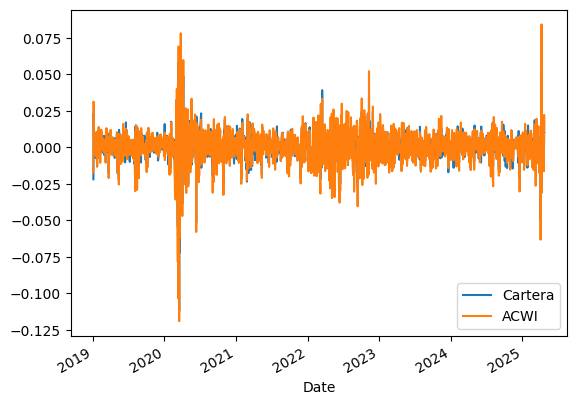

In [ ]:
df_cart_acwi.plot()

<Axes: xlabel='Date'>

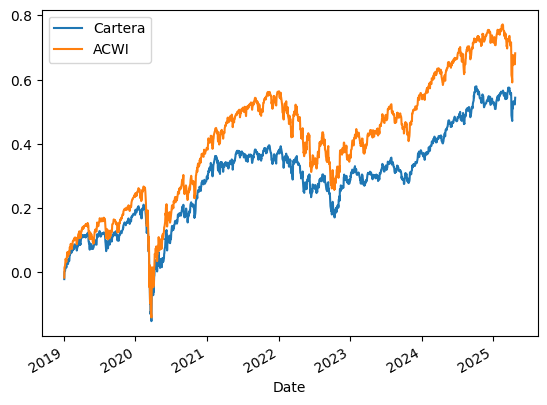

In [ ]:
df_cart_acwi.cumsum().plot()

In [ ]:
df_cart_acwi.iloc[:,1]

,ACWI
Date,
2019-01-03,-0.017140
2019-01-04,0.031382
2019-01-07,0.006130
2019-01-08,0.007306
2019-01-09,0.009208
...,...
2025-04-16,-0.016008
2025-04-17,0.004228
2025-04-21,-0.016290


#Estimación de indicadores

##Beta frente a índice de referencia
Índice utilizado: MSCI All Country World Index

In [ ]:
def calc_regresion_ind(df_ind,df_cartera_ret):
  df = pd.concat([df_ind,df_cartera_ret],axis=1, join='inner')

  Y = df.iloc[:,1]
  X = df.iloc[:,0]
  Xc = sm.add_constant(X)

  modelo = sm.OLS(Y, Xc).fit()

  return modelo.summary()

In [ ]:
summ_ind=calc_regresion_ind(df_ind=ind_ret,df_cartera_ret=cartera_ret)
print(summ_ind)

                            OLS Regression Results                            
Dep. Variable:                Cartera   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     9350.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:46:52   Log-Likelihood:                 6600.7
No. Observations:                1585   AIC:                        -1.320e+04
Df Residuals:                    1583   BIC:                        -1.319e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.131e-05   9.46e-05      0.225      0.8

##Análisis de exposición a los factores de Fama y French

**Cálculo de factores globales**

Dado que en la página oficial de Fama&French no se encuentran disponibles factores globales que engloben tanto los mercados desarrollados como los emergentes, se hará un cálculo aproximado de este usando:

+ Los factores Fama&French de US, Developed ex US y Emerging
+ Market caps basados en MSCI ACWI IMI, basado en el desglose geográfico del índice a fecha del 31 dec. 2024, disponible en https://www.msci.com/research-and-insights/visualizing-investment-data/acwi-imi-complete-geographic-breakdown

De esta forma, se hará una media ponderada de los factores con dichos pesos para obtener una aproximación que, aunque limitada, se espera que capture mejor el comportamiento de la cartera, que incluye varios elementos fuera del mercado estounidense

In [ ]:
def calc_regresion_facores(df_factores,df_cartera_ret):
  df = pd.concat([df_factores,df_cartera_ret],axis=1, join='inner')

  Y = df[df_cartera_ret.name]- df['RF']
  X = df[df_factores.columns.difference(['RF'])]
  Xc = sm.add_constant(X)

  modelo = sm.OLS(Y, Xc).fit()

  return modelo.summary()

In [ ]:
developed_file='https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_ex_US_5_Factors_Daily_CSV.zip'
usa_file='https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip'
emerging_file='https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Emerging_5_Factors_CSV.zip'


In [ ]:
usa_ff=pd.read_csv(usa_file,skiprows=2, index_col=0, na_values=-99.99, parse_dates=True,date_format='%Y%m%d')/100
usa_ff

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,-0.0067,0.0002,-0.0035,0.0003,0.0013,0.00012
1963-07-02,0.0079,-0.0028,0.0028,-0.0008,-0.0021,0.00012
1963-07-03,0.0063,-0.0018,-0.0010,0.0013,-0.0025,0.00012
1963-07-05,0.0040,0.0009,-0.0028,0.0007,-0.0030,0.00012
1963-07-08,-0.0063,0.0007,-0.0020,-0.0027,0.0006,0.00012
...,...,...,...,...,...,...
2024-12-24,0.0111,-0.0012,-0.0005,-0.0013,-0.0037,0.00017
2024-12-26,0.0002,0.0109,-0.0019,-0.0044,0.0035,0.00017
2024-12-27,-0.0117,-0.0044,0.0056,0.0041,0.0003,0.00017
2024-12-30,-0.0109,0.0024,0.0074,0.0055,0.0014,0.00017


In [ ]:
developed_ff=pd.read_csv(developed_file,skiprows=3, index_col=0, na_values=-99.99, parse_dates=True,date_format='%Y%m%d')/100
developed_ff.index = pd.to_datetime(developed_ff.index, format='%Y%m%d')
developed_ff

,Mkt-RF,SMB,HML,RMW,CMA,RF
1990-07-02,0.0087,0.0008,-0.0039,0.0007,0.0003,0.0003
1990-07-03,0.0020,0.0021,0.0002,-0.0013,0.0020,0.0003
1990-07-04,0.0093,-0.0024,-0.0028,-0.0005,0.0004,0.0003
1990-07-05,-0.0061,0.0024,0.0013,-0.0015,0.0005,0.0003
1990-07-06,0.0001,-0.0001,0.0025,0.0006,-0.0004,0.0003
...,...,...,...,...,...,...
2025-03-25,0.0051,-0.0002,0.0027,0.0003,0.0005,0.0002
2025-03-26,-0.0062,0.0049,0.0051,0.0035,0.0031,0.0002
2025-03-27,-0.0002,0.0008,0.0008,-0.0015,0.0022,0.0002
2025-03-28,-0.0055,0.0029,-0.0015,0.0019,0.0039,0.0002


In [ ]:
emerging_ff=pd.read_csv(emerging_file,skiprows=3, index_col=0, nrows=429, na_values=-99.99, parse_dates=True,date_format='%Y%m')/100
emerging_ff.index = pd.to_datetime(emerging_ff.index, format='%Y%m')
emerging_ff=emerging_ff.dropna(axis=0,how='any')
emerging_ff

,Mkt-RF,SMB,HML,RMW,CMA,RF
1992-07-01,-0.0049,0.0174,-0.0200,0.0393,-0.0272,0.0031
1992-08-01,-0.0364,-0.0025,-0.0230,0.0357,-0.0225,0.0026
1992-09-01,-0.0122,-0.0329,-0.0011,0.0134,0.0098,0.0026
1992-10-01,0.0440,0.0000,-0.0075,-0.0267,-0.0513,0.0023
1992-11-01,-0.0072,0.0279,-0.0061,0.0016,-0.0879,0.0023
...,...,...,...,...,...,...
2024-11-01,-0.0339,0.0140,0.0151,0.0045,0.0025,0.0040
2024-12-01,-0.0079,-0.0095,-0.0092,0.0283,-0.0120,0.0037
2025-01-01,0.0065,-0.0276,-0.0082,0.0046,-0.0213,0.0037
2025-02-01,-0.0066,-0.0015,-0.0181,-0.0258,0.0199,0.0033


In [ ]:
#Filtro de fechas
dates=pd.concat([usa_ff,developed_ff,emerging_ff],join='inner',axis=1).index
usa_ff=usa_ff.loc[dates,:]
developed_ff=developed_ff.loc[dates,:]
emerging_ff=emerging_ff.loc[dates,:]

In [ ]:
mkt_cap=[0.626,0.283,0.091] #for usa, developed, emerging respectively

ff_global = pd.DataFrame(index=usa_ff.index, columns=usa_ff.columns)

for column in usa_ff.columns:
  ff_global[column] = (usa_ff[column]*mkt_cap[0] + developed_ff[column]*mkt_cap[1] + emerging_ff[column]*mkt_cap[2])

ff_global

,Mkt-RF,SMB,HML,RMW,CMA,RF
1992-07-01,0.008419,-0.002639,-0.005415,0.005441,-0.002250,0.000398
1992-09-01,0.000914,-0.001998,-0.003849,0.002804,-0.000689,0.000340
1992-10-01,-0.000675,-0.002973,0.001402,-0.001010,-0.004474,0.000300
1992-12-01,0.001955,0.003299,-0.001936,0.001802,-0.000164,0.000364
1993-02-01,0.006824,-0.000867,0.006441,-0.002554,0.002832,0.000304
...,...,...,...,...,...,...
2024-05-01,0.000526,0.005962,0.000472,-0.008897,0.000949,0.000582
2024-07-01,0.002093,-0.007649,0.002242,0.000628,-0.000269,0.000598
2024-08-01,-0.014796,-0.006998,-0.005008,0.007409,-0.005881,0.000631
2024-10-01,-0.010758,-0.002891,-0.000250,0.004928,-0.003772,0.000518


In [ ]:
summ_ff=calc_regresion_facores(df_factores=ff_global, df_cartera_ret=cartera_ret)
print(summ_ff)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     25.50
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           7.39e-12
Time:                        23:46:54   Log-Likelihood:                 190.45
No. Observations:                  49   AIC:                            -368.9
Df Residuals:                      43   BIC:                            -357.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.926      0.3

##Análisis de factores sectoriales

In [ ]:
def calc_regresion_sector(df_factores,df_cartera_ret):
  df = pd.concat([df_factores,df_cartera_ret],axis=1, join='inner')

  Y = df[df_cartera_ret.name]
  X = df[df_factores.columns]
  Xc = sm.add_constant(X)

  modelo = sm.OLS(Y, Xc).fit()

  return modelo.summary()

In [ ]:
sectors_file='http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/12_Industry_Portfolios_daily_CSV.zip'
sectors=pd.read_csv(sectors_file,skiprows=9, nrows=25901, index_col=0, na_values=-99.99, parse_dates=True,date_format='%Y%m%d')/100
sectors

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
1926-07-01,0.0002,-0.0028,-0.0041,0.0057,0.0052,-0.0025,-0.0002,0.0061,-0.0001,0.0097,0.0058,0.0019
1926-07-02,0.0029,0.0107,0.0083,0.0064,0.0097,0.0013,0.0026,0.0047,0.0001,0.0013,-0.0016,0.0011
1926-07-06,0.0024,0.0072,0.0024,0.0017,0.0023,0.0044,0.0017,0.0073,-0.0023,0.0023,0.0020,-0.0020
1926-07-07,0.0027,0.0006,0.0005,-0.0004,0.0073,-0.0001,0.0032,0.0017,-0.0059,0.0033,-0.0007,0.0017
1926-07-08,0.0069,0.0005,0.0023,0.0012,-0.0009,0.0036,0.0040,-0.0020,-0.0036,0.0091,-0.0048,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.0045,0.0610,0.0065,0.0064,0.0053,0.0104,0.0063,0.0068,0.0145,0.0042,0.0114,0.0102
2024-12-26,-0.0003,-0.0134,0.0018,0.0002,0.0026,0.0003,0.0013,-0.0036,-0.0020,0.0022,0.0035,0.0012
2024-12-27,-0.0018,-0.0414,-0.0088,0.0003,-0.0061,-0.0144,-0.0058,-0.0030,-0.0114,-0.0074,-0.0091,-0.0088
2024-12-30,-0.0090,-0.0282,-0.0115,0.0016,-0.0124,-0.0109,-0.0103,-0.0017,-0.0119,-0.0138,-0.0084,-0.0095


In [ ]:
summ_sectors=calc_regresion_sector(df_factores=sectors,df_cartera_ret=cartera_ret)
print(summ_sectors)

                            OLS Regression Results                            
Dep. Variable:                Cartera   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     553.8
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:46:56   Log-Likelihood:                 6117.0
No. Observations:                1509   AIC:                        -1.221e+04
Df Residuals:                    1496   BIC:                        -1.214e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -1.023      0.3

#Backtesting
Contrastar el rendimiento esperado (ex-ante) con el rendimiento realizado (ex-post).

In [ ]:
#Bear period caída en 2022
bear_start = '2022-01-01'
bear_end = '2022-09-30'

#Bull period recuperación de 2024
bull_start = '2024-01-01'
bull_end = '2024-10-01'

bear_ret = cartera_ret[bear_start:bear_end]
bull_ret = cartera_ret[bull_start:bull_end]

In [ ]:
def calc_period(ret, period_name):
  stats = {
    'Rentabilidad Anualizado': ret.mean() * 252,
    'Volatilidad Anualizada': ret.std() * np.sqrt(252),
    'Sharpe Ratio': (ret.mean() * 252) / (ret.std() * np.sqrt(252)),
    'Máxima Caída': ret.min(),
    'Rentabilidad Total': np.exp(ret.sum()) - 1} #no es cumprod porque nos interesa la final

  print(f"\nEstadísticas para {period_name}:")
  for clave, valor in stats.items():
    print(f"{clave}: {valor:.4f}")

  return stats

In [ ]:
bear_stats = calc_period(bear_ret, 'Bear period 2022')
bull_stats = calc_period(bull_ret, 'Bull period 2024')


Estadísticas para Bear period 2022:
Rentabilidad Anualizado: -0.2624
Volatilidad Anualizada: 0.1623
Sharpe Ratio: -1.6167
Máxima Caída: -0.0298
Rentabilidad Total: -0.1778

Estadísticas para Bull period 2024:
Rentabilidad Anualizado: 0.2496
Volatilidad Anualizada: 0.0984
Sharpe Ratio: 2.5359
Máxima Caída: -0.0155
Rentabilidad Total: 0.2059


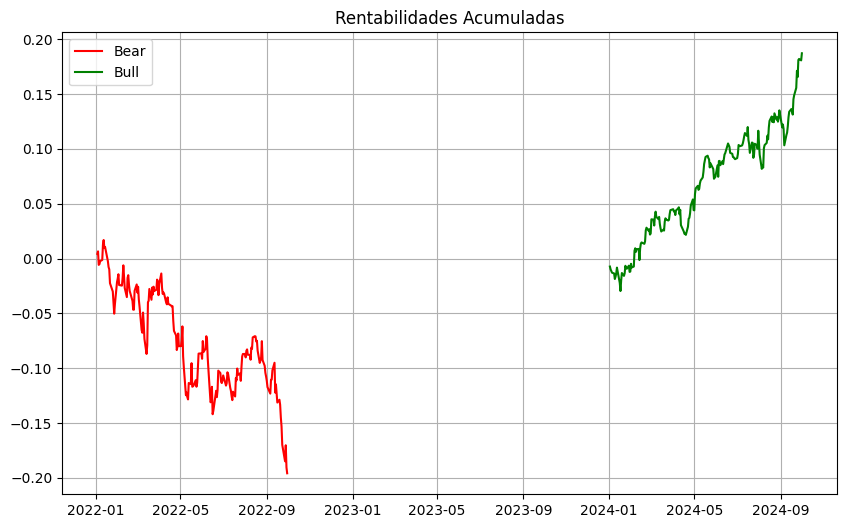

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(bear_ret.cumsum(), label='Bear', color='red')
plt.plot(bull_ret.cumsum(), label='Bull', color='green')

plt.title('Rentabilidades Acumuladas')

plt.legend()
plt.grid()

plt.show()

In [ ]:
#Para comparar con el índice
bear_benchmark = ind_ret[bear_start:bear_end]
bull_benchmark = ind_ret[bull_start:bull_end]

##Periodo de crecimiento bursátil (bull market)

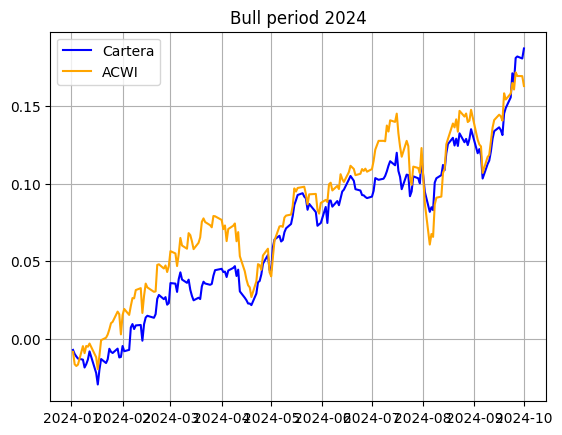

In [ ]:
figsize=(20, 6)

plt.plot(bull_ret.cumsum(), label='Cartera', color='b')
plt.plot(bull_benchmark.cumsum(), label='ACWI', color='orange')
plt.title('Bull period 2024')

plt.legend()
plt.grid()

plt.show()

##Periodo de recesión (bear market)

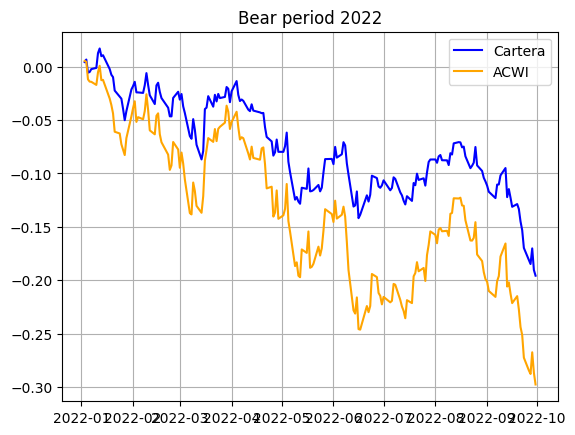

In [ ]:
figsize=(20, 6)

plt.plot(bear_ret.cumsum(), label='Cartera', color='b')
plt.plot(bear_benchmark.cumsum(), label='ACWI', color='orange')
plt.title('Bear period 2022')

plt.legend()
plt.grid()

plt.show()

## Análisis Ex-Ante vs Ex-Post

Se usará el periodo 2019-2022 para utilizar la rentabilidad media anualizada como baremo para medir la rentabilidad esperada ex-ante.

Como los periodos bear y bull son consecutivos se usará esta media para comparar ambos periodos, ya que no tendría sentido utilizar la media del periodo bear como rentabilidad esperada para el siguiente periodo.

In [ ]:
#Cartera
bear_ex_ante = cartera_ret['2019-01-01':'2021-12-31'].mean() * 252
bear_ex_post = cartera_ret[bear_start:bear_end].mean() * 252

bull_ex_ante = cartera_ret['2019-01-01':'2021-12-31'].mean() * 252
bull_ex_post = cartera_ret[bull_start:bull_end].mean() * 252

#Indice
bear_ex_ante_acwi = ind_ret['2019-01-01':'2021-12-31'].mean() * 252
bear_ex_post_acwi = ind_ret[bear_start:bear_end].mean() * 252

bull_ex_ante_acwi = ind_ret['2019-01-01':'2021-12-31'].mean() * 252
bull_ex_post_acwi = ind_ret[bull_start:bull_end].mean() * 252

results = pd.DataFrame({
  'Periodo': ['Bear period (2022)', 'Bull period (2024)'],
  'Rendimiento Esperado (Ex-ante)': [bear_ex_ante, bull_ex_ante],
  'Rendimiento Realizado (Ex-post)': [bear_ex_post, bull_ex_post],
  'Diferencia': [bear_ex_post - bear_ex_ante, bull_ex_post - bull_ex_ante],
  'Diferencia ACWI':[(bear_ex_post_acwi - bear_ex_ante_acwi).iloc[0], (bull_ex_post_acwi - bull_ex_ante_acwi).iloc[0]]}) #iloc[0] para que solo salga el numero

results

,Periodo,Rendimiento Esperado (Ex-ante),Rendimiento Realizado (Ex-post),Diferencia,Diferencia ACWI
0,Bear period (2022),0.125138,-0.262383,-0.387522,-0.584702
1,Bull period (2024),0.125138,0.249617,0.124479,0.031513


<ipython-input-60-78df6350b1d5>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  valores = [float(bear_ex_ante), float(bear_ex_post), float(bear_ex_post_acwi), float(bull_ex_ante), float(bull_ex_post),float(bull_ex_post_acwi)]


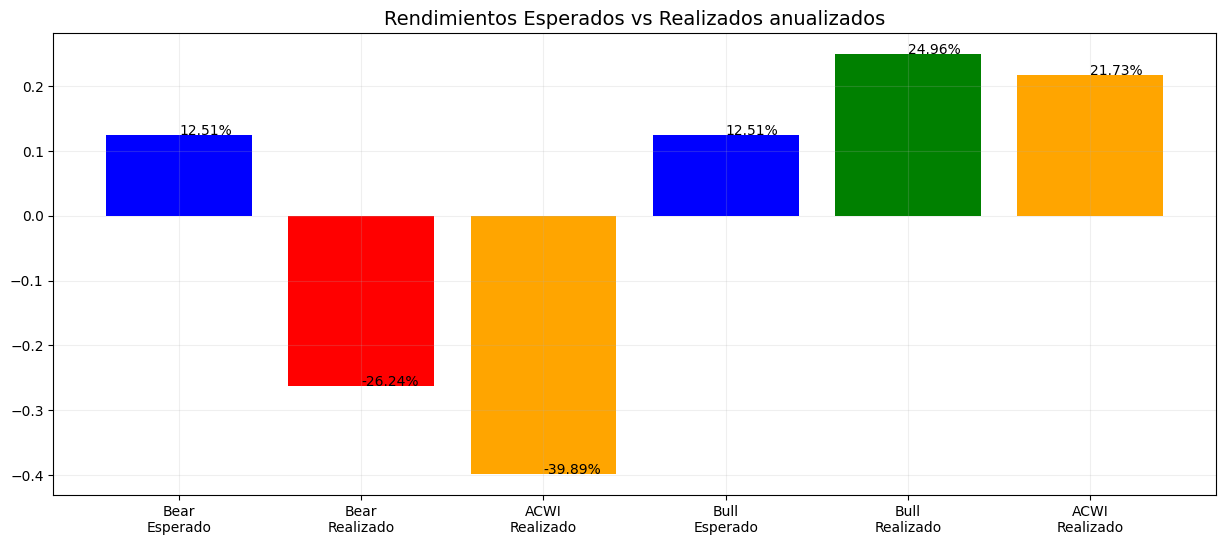

In [ ]:
plt.figure(figsize=(15, 6))


#Lista con los valores a poner en cada posición
valores = [float(bear_ex_ante), float(bear_ex_post), float(bear_ex_post_acwi), float(bull_ex_ante), float(bull_ex_post),float(bull_ex_post_acwi)]

posiciones = np.arange(len(valores))
plt.bar(posiciones, valores, color=['blue', 'red', 'orange','blue', 'green','orange'])


plt.title('Rendimientos Esperados vs Realizados anualizados', fontsize=14)
plt.xticks(posiciones, ['Bear\nEsperado', 'Bear\nRealizado','ACWI\nRealizado', 'Bull\nEsperado', 'Bull\nRealizado','ACWI\nRealizado'])
plt.grid(alpha=0.2)

#Poner porcentajes
for i, v in enumerate(valores):
  plt.text(i, v, f'{v:.2%}')

plt.show()

La cartera, aunque también se ve afectada por periodos de crisis y, por lo tanto, incertidumbre, consigue una caída menor a la de su índice de referencia, mientras que, a la vez, parece obtener una rentabilidad ligeramente mayor en periodos alcistas

#Estimación del Riesgo
+ Estimar el Value at Risk (VaR) mensual de la cartera, al 95% de confianza, utilizando el método de Monte Carlo.

+ Incluir al menos 100,000 simulaciones, con supuestos de distribución claros y justificados.

Preceso Browniano standard o un proceso de Wiener: modelo matemático utilizado para describir la evolución aleatoria de un sistema a lo largo del tiempo.

La ecuación diferencial que define un proceso geométrico Browiano de una acción es la siguiente:

$$dS_t=rS_tdt+\sigma S_t dZ_t$$

Si aplicamos el esquema de Euler para pasar de tiempo continuo a tiempo discreto llegamos a la expresión de Black-Schole-Merton
$$ S_t=S_{t-\bigtriangleup t}exp\left[\left(r-\frac{1}{2}\sigma^2\right)\bigtriangleup t+\sigma\sqrt{\bigtriangleup t}z_t\right] $$


In [ ]:
num_simulaciones = 100000 #Son 100000 simulaciones pero en los gráficos de línea no se representarán todos
num_intervalos = 252 #daily
T = 1 #periodo de un año
dt = T / num_intervalos
precio_inicial = activos_price[-1] # Precio inicial = Precio final conocido
retorno_medio = cartera_ret_m
volatilidad = cartera_std

#Matriz de precios
precios_mc = np.zeros((num_intervalos + 1, num_simulaciones))
precios_mc[0] = precio_inicial  # Establecer el valor inicial para todas las simulaciones

#Generación de valores aleatorios (componente de difusión)
valores_aleatorios = np.random.default_rng(seed=42).standard_normal((num_intervalos, num_simulaciones))

# Simulación de precios (operaciones vectorizadas)
precios_mc[1:] = precio_inicial * np.exp(np.cumsum((retorno_medio - 0.5 * volatilidad**2) * dt + volatilidad * np.sqrt(dt) * valores_aleatorios, axis=0))

<ipython-input-43-4ccd4196b8b1>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  precio_inicial = activos_price[-1] # Precio inicial = Precio final conocido


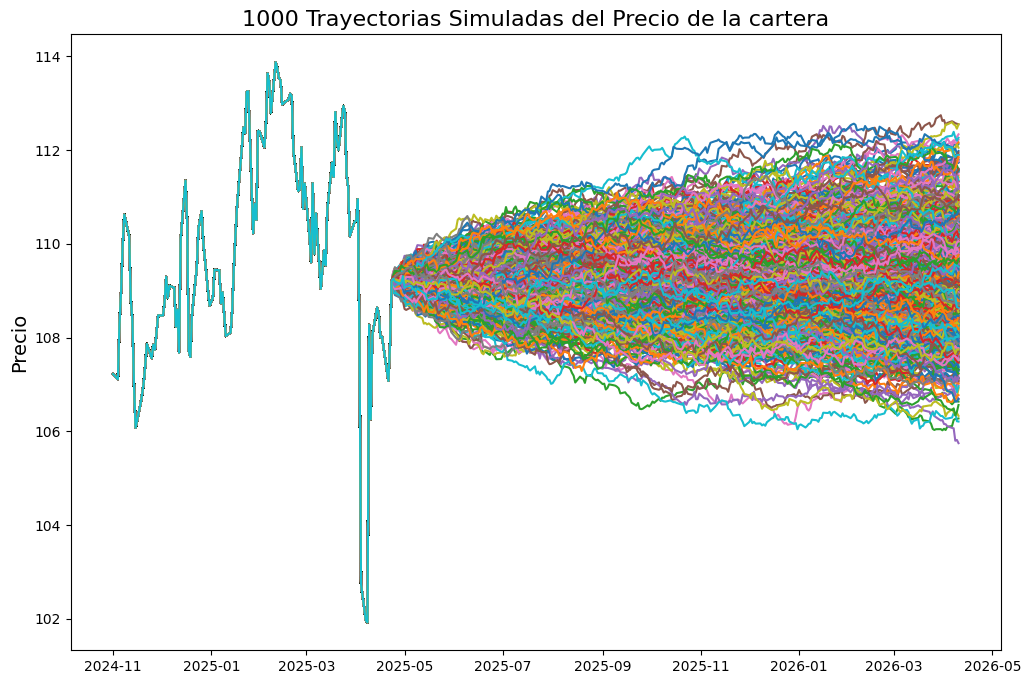

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(1000):
  #plt.plot(precios_mc[:, i], lw=1.5, label=f'Trayectoria {i+1}')
  plt.plot(pd.concat([activos_price['2024-11-01':], pd.DataFrame(precios_mc[:, i],index=pd.bdate_range(start=activos_price.index[-1], periods=num_intervalos+1))],axis=0), lw=1.5, label=f'Trayectoria {i+1}')

plt.title('1000 Trayectorias Simuladas del Precio de la cartera', fontsize=16)
plt.ylabel('Precio', fontsize=14)

#plt.legend()

plt.show()

In [ ]:
simulaciones_ret=np.log(pd.DataFrame(precios_mc,index=pd.bdate_range(start=cartera_ret.index[-1], periods=num_intervalos+1))).diff().dropna()
simulaciones_ret.shape

(252, 100000)

In [ ]:
simulaciones_ret

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
2025-04-24,0.000191,-0.000646,0.000468,0.000587,-0.001214,-0.000810,0.000081,-0.000196,-0.000009,-0.000530,...,-0.000295,-0.001203,-0.000986,-0.000312,-0.000516,0.000621,0.000460,0.000937,-0.000094,0.000409
2025-04-25,-0.000979,0.001490,0.001120,-0.000515,0.000998,-0.000715,-0.000418,0.000007,-0.000545,0.000378,...,-0.000489,0.000272,0.000566,0.000774,0.001339,-0.000047,0.000331,0.000402,0.000708,0.000169
2025-04-28,0.001631,-0.000086,-0.000288,-0.000705,-0.000158,-0.000169,-0.000152,0.000238,-0.000557,-0.000780,...,0.000420,0.000246,0.000469,0.000703,0.000558,0.000315,-0.000205,-0.000278,0.000153,0.000284
2025-04-29,0.001091,0.000408,-0.000252,0.000154,-0.000500,0.000419,0.000011,-0.000436,-0.000536,0.000155,...,-0.000110,-0.000127,-0.000780,0.000612,-0.000792,-0.000373,0.000564,0.001457,-0.000186,0.001139
2025-04-30,0.001126,-0.000279,-0.000884,0.000976,0.000207,0.000068,-0.000389,0.000845,-0.000337,-0.000069,...,0.000533,-0.000686,-0.000604,-0.000672,-0.000368,-0.001057,0.001060,0.000285,0.001058,-0.000411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-04-06,0.001220,0.000171,-0.000479,0.000118,0.000655,0.000732,0.000131,-0.000954,0.000150,0.000030,...,0.000639,0.000290,0.000107,0.000551,-0.000354,0.000457,-0.000304,0.000200,-0.000107,-0.000165
2026-04-07,-0.000270,-0.000002,0.000892,0.000349,0.000665,-0.000204,-0.000322,0.000182,0.000093,0.000793,...,-0.000967,0.001259,0.000455,0.000732,0.000969,0.001068,0.000392,0.000384,-0.000207,-0.000664
2026-04-08,-0.000375,-0.000350,-0.000222,-0.000285,0.001116,-0.000361,0.000087,0.000385,-0.000292,0.000668,...,-0.000048,0.000442,0.000079,-0.000911,0.001016,0.000175,-0.000448,0.000241,0.000007,0.000275
2026-04-09,0.000385,-0.000299,-0.000809,0.000005,0.000594,0.000671,0.000614,-0.000202,-0.000294,-0.000243,...,-0.000011,-0.000179,0.000191,0.000864,-0.000653,-0.000261,0.000268,0.000100,0.000994,0.000542


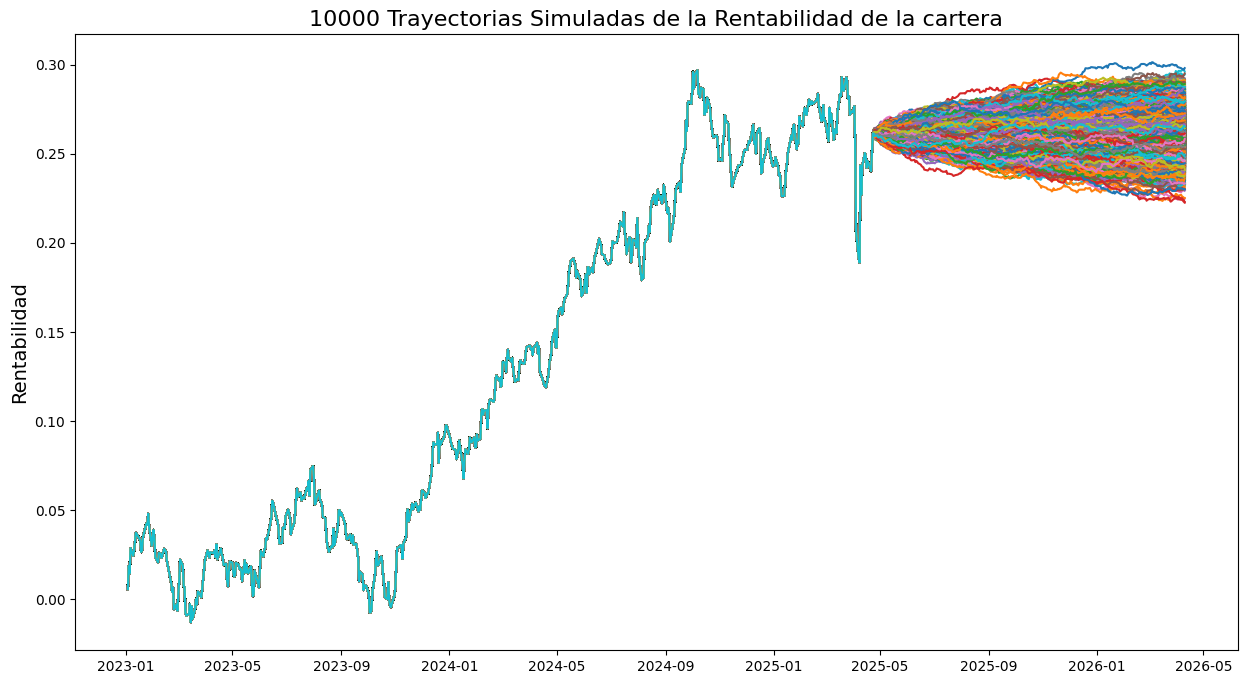

In [ ]:
plt.figure(figsize=(15, 8))

for i in range(10000):
  #plt.plot(simulaciones_ret.iloc[:, i].cumsum()) #solo las trayectorias
  plt.plot(pd.concat([cartera_ret['2023-01-01':], simulaciones_ret.iloc[:, i]]).cumsum())

# Añadir título y etiquetaprecios a la gráfica
plt.title('10000 Trayectorias Simuladas de la Rentabilidad de la cartera', fontsize=16)
plt.ylabel('Rentabilidad', fontsize=14)

plt.show()

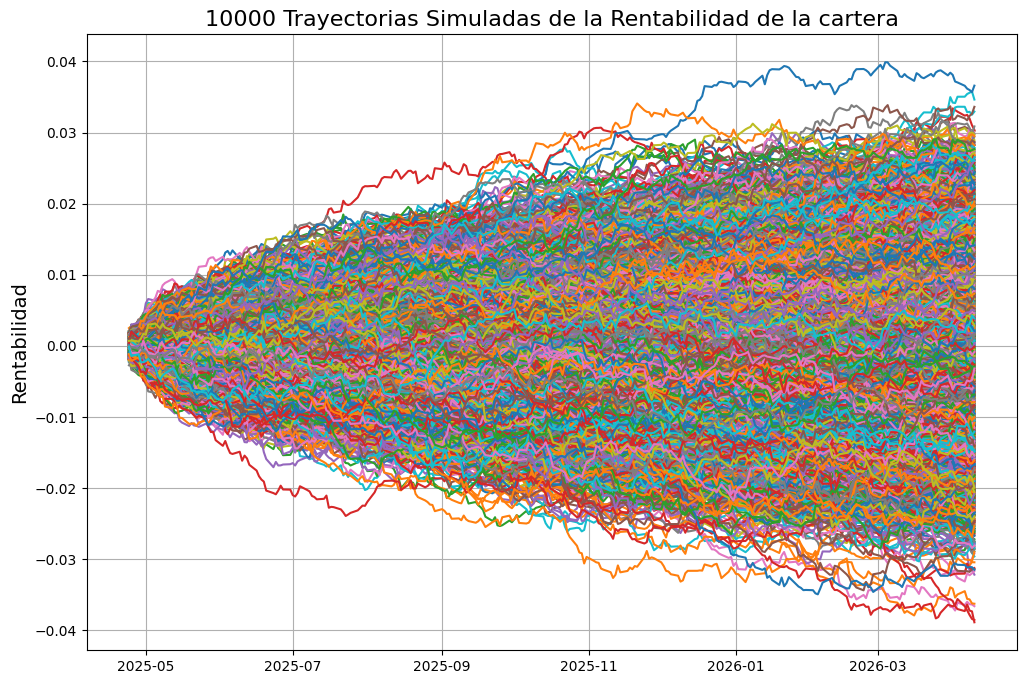

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(10000):
  plt.plot(simulaciones_ret.iloc[:, i].cumsum()) #solo las trayectorias
  #plt.plot(pd.concat([cartera_ret['2023-01-01':], simulaciones_ret.iloc[:, i]]).cumsum())

# Añadir título y etiquetaprecios a la gráfica
plt.title('10000 Trayectorias Simuladas de la Rentabilidad de la cartera', fontsize=16)
plt.ylabel('Rentabilidad', fontsize=14)

plt.grid()
plt.show()

In [ ]:
rent_final=np.sort(simulaciones_ret.iloc[-1,:])
print(f"Rentabilidad Mínima anualizada: {rent_final[0]*252}")
print(f"Rentabilidad Máxima anualizada: {rent_final[-1]*252}")
print(f"Rentabilidad Media anualizada: {rent_final.mean()*252}")

var_95 = np.percentile(rent_final, 5)
print(f"VaR 95% anualizado: {var_95*252}")

cvar_95=rent_final[rent_final < var_95].mean()
print(f"CVaR 95% anualizado: {cvar_95*252}")


Rentabilidad Mínima anualizada: -0.8280519174576497
Rentabilidad Máxima anualizada: 0.6699216872413949
Rentabilidad Media anualizada: 0.000146324611016072
VaR 95% anualizado: -0.25808021043501594
CVaR 95% anualizado: -0.32283308281462086


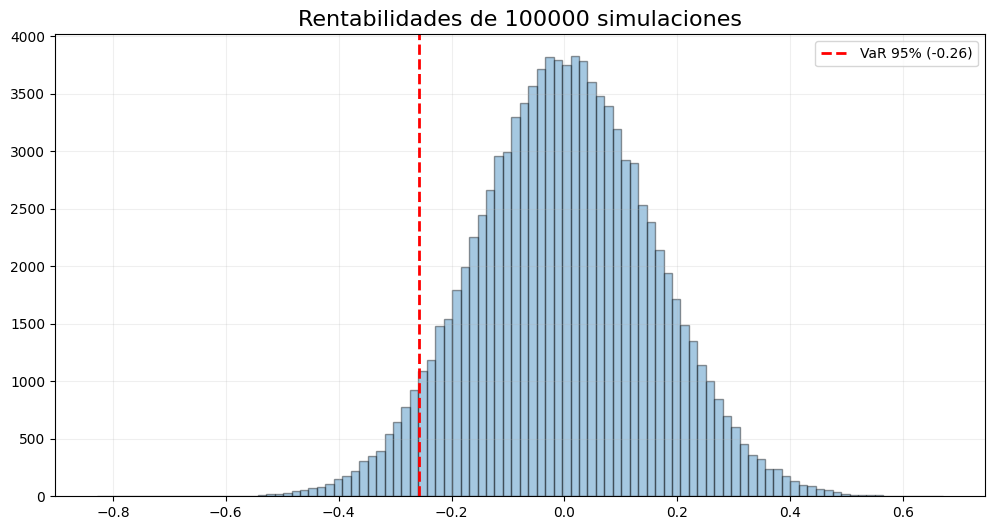

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(rent_final*252, bins=100, alpha=0.4, edgecolor='black')

plt.axvline(var_95*252, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95% ({var_95*252:.2f})')

plt.title('Rentabilidades de 100000 simulaciones', fontsize=16)

plt.legend()
plt.grid(alpha=0.2)

plt.show()


In [ ]:
print(pd.DataFrame(rent_final*252).describe(),f'\nCvar anualizado:{cvar_95*252:.5f}')

                   0
count  100000.000000
mean        0.000146
std         0.156775
min        -0.828052
25%        -0.105838
50%         0.000084
75%         0.105852
max         0.669922 
Cvar anualizado:-0.32283


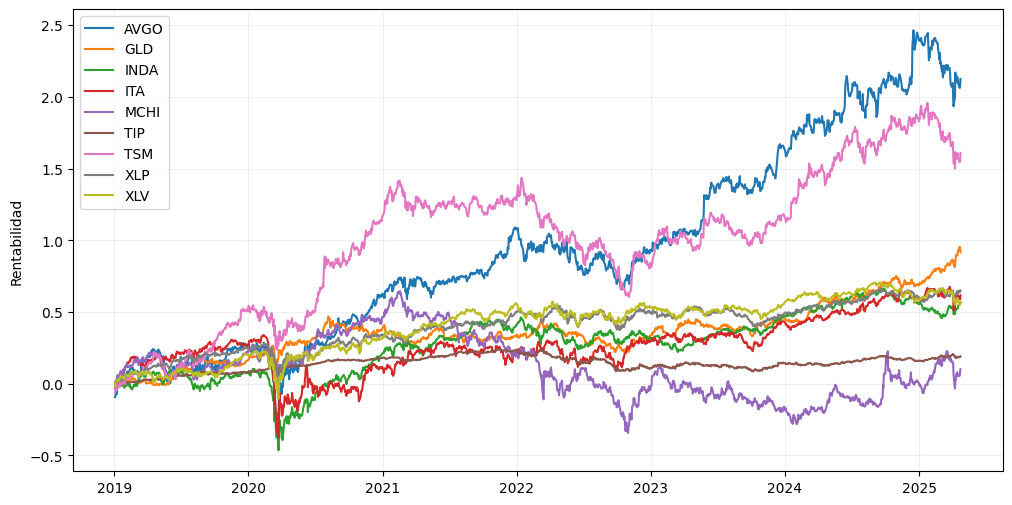

In [ ]:
plt.figure(figsize=(12, 6))

for activo in activos.columns:
  plt.plot(activos_ret[activo].cumsum(), label=activo)

plt.ylabel('Rentabilidad')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

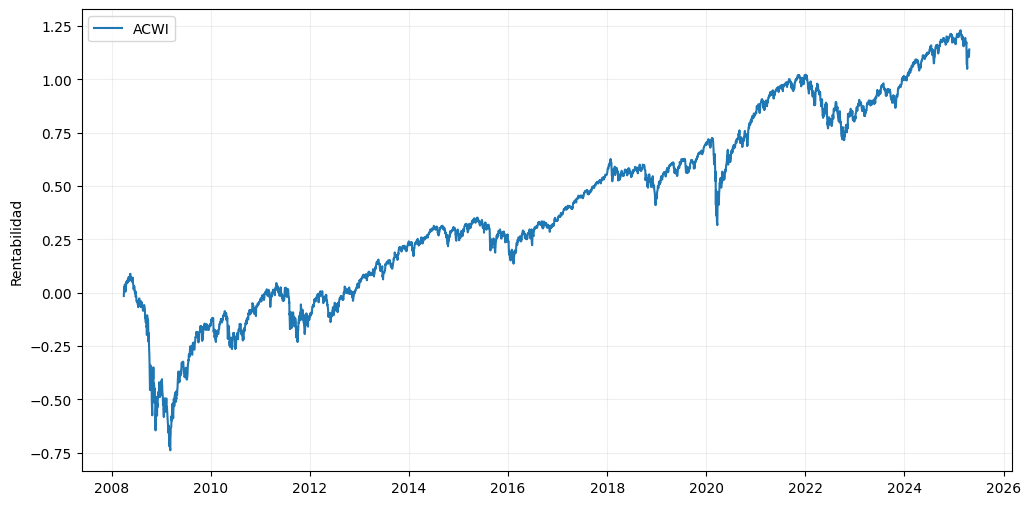

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(ind_ret.cumsum(),label='ACWI')

plt.ylabel('Rentabilidad')
plt.legend()
plt.grid(alpha=0.2)
plt.show()